In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from IPython.display import Image, display
import re
from functools import reduce

## Load data
sources: https://databank.worldbank.org/source/world-development-indicators 

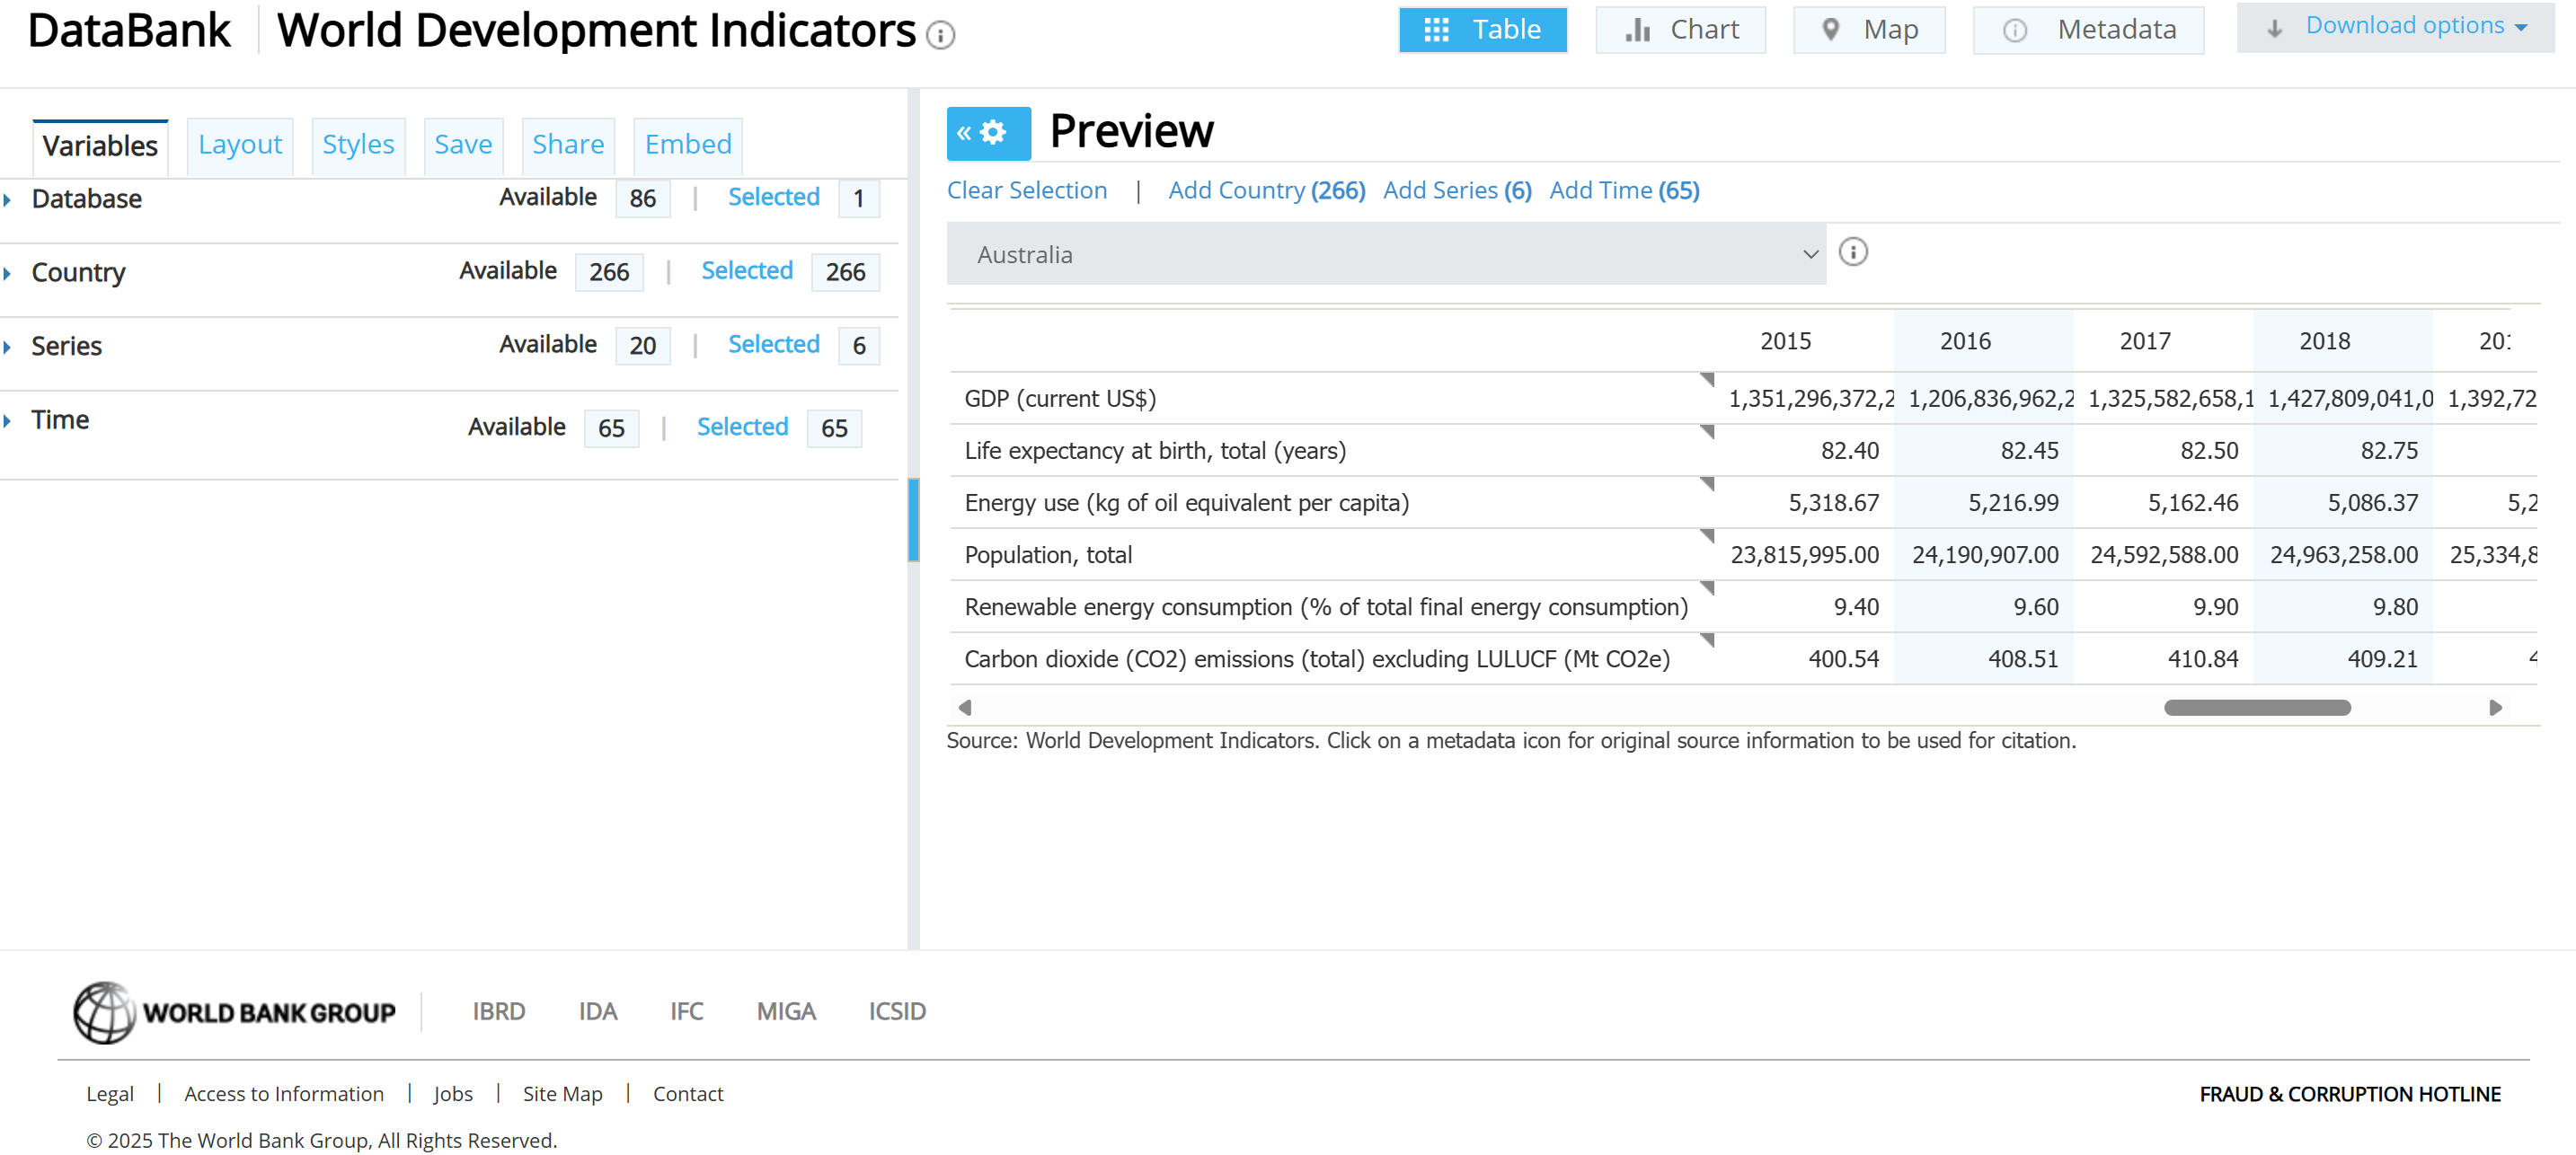

In [2]:
display(Image("Project/dataset/data_from_worldbank.png"))

In [3]:
# CONFIG
CONFIG = {
    "files": {
        "merged_csv": None, 
        "gdp_csv": "Project/dataset/GDP.csv",
        "pop_csv": "Project/dataset/Population.csv",
        "lifeexp_csv": "Project/dataset/life_expectancy.csv",
        "energy_use_csv": "Project/dataset/Energy_use.csv",
        "renewable_pct_csv": "Project/dataset/Renewable_energy_consumption.csv",
        "co2_csv": "Project/dataset/Carbon_dioxide_(CO2)_emissions_(total).csv",
    },
    "year_min": 1970,
    "year_max": 2023,

    "key_features": [
        "GDP_current_usd","Population_total","LifeExp_years",
        "Energy_use_kg_oil_pc","Renewable_energy_pct","CO2_total_mt"
    ],

    # Country filtering rules (time-series first)
    "country_missing_ratio_max": 0.40,   # Average missing ratio of key_features per country must not exceed 40%
    "min_years_required": 20,            # Country must have at least this many usable years
    "per_year_min_features_ratio": 0.6,  # Each year must have ≥60% non-null values of key_features to be considered usable

    # Per-feature per-country drop rules (if missing ratio of this feature > threshold → drop the country)
    "per_feature_country_drop": {
        "Energy_use_kg_oil_pc": 0.7,
        "Renewable_energy_pct": 0.8,
    },

    # Filter out aggregates/income groups/regions (check substrings in Country Name)
    "ban_names_contains": [
        "income","europe","asia","africa","america","world","union",
        "euro area","high income","upper middle","lower middle","low income",
        "sar","occupied","channel islands"],

    # Export options
    "export_prefix": "", 
    "topn_print": 10,     
}

# map: key file
VALUE_NAME_MAP = {
    "gdp_csv": "GDP_current_usd",
    "pop_csv": "Population_total",
    "lifeexp_csv": "LifeExp_years",
    "energy_use_csv": "Energy_use_kg_oil_pc",
    "renewable_pct_csv": "Renewable_energy_pct",
    "co2_csv": "CO2_total_mt",}

# Utils: wide→long
def _to_numeric_safe(s): 
    return pd.to_numeric(s, errors="coerce")

def _parse_year_from_col(col: str):
    if col is None: 
        return None
    s = str(col).strip()
    for pat in [r"^(\d{4})$", r"^(\d{4})\s*\[\s*YR\d{4}\s*\]$", r"^YR?(\d{4})$", r"^(\d{4})-\d{1,2}", r"^(\d{4})\b"]:
        m = re.match(pat, s, flags=re.IGNORECASE)
        if m:
            y = int(m.group(1))
            if 1800 <= y <= 2100:
                return y
    return None

def _rename_year_columns(df: pd.DataFrame) -> pd.DataFrame:
    colmap = {}
    for c in df.columns:
        y = _parse_year_from_col(c)
        if y is not None:
            colmap[c] = str(y)
    if colmap:
        df = df.rename(columns=colmap)
    return df

def _ensure_year_long(df: pd.DataFrame, value_name: str) -> pd.DataFrame:
    df = df.copy()
    rename_guess = {}
    for c in df.columns:
        cl = c.lower()
        if cl == "country": rename_guess[c] = "Country Name"
        if cl == "name":    rename_guess[c] = "Country Name"
        if cl == "code":    rename_guess[c] = "Country Code"
    if rename_guess:
        df = df.rename(columns=rename_guess)

    # Year
    if "Year" in df.columns:
        df["Year"] = _to_numeric_safe(df["Year"]).astype("Int64")
        if value_name in df.columns:
            vc = value_name
        elif "Value" in df.columns:
            vc = "Value"
        else:
            numc = [c for c in df.columns if c not in ["Country Name","Country Code","Year","Date"]]
            vc = numc[0] if len(numc) == 1 else value_name
            if vc == value_name and value_name not in df.columns:
                df[vc] = np.nan
        out = df[["Country Name","Country Code","Year", vc]].copy()
        out = out.rename(columns={vc: value_name})
        out[value_name] = _to_numeric_safe(out[value_name])
        return out

    # wide → long
    df = _rename_year_columns(df)
    year_cols = [c for c in df.columns if re.fullmatch(r"\d{4}", str(c or ""))]
    if year_cols:
        id_vars = []
        if "Country Name" in df.columns: id_vars.append("Country Name")
        if "Country Code" in df.columns: id_vars.append("Country Code")
        if not id_vars: id_vars = list(df.columns[:2])
        melted = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name=value_name)
        if "Country Name" not in melted.columns:
            melted = melted.rename(columns={id_vars[0]: "Country Name"})
        if "Country Code" not in melted.columns and len(id_vars) > 1:
            melted = melted.rename(columns={id_vars[1]: "Country Code"})
        melted["Year"] = _to_numeric_safe(melted["Year"]).astype("Int64")
        melted[value_name] = _to_numeric_safe(melted[value_name])
        if "Country Code" not in melted.columns:
            melted["Country Code"] = np.nan
        return melted[["Country Name","Country Code","Year", value_name]]

    raise ValueError(f" error (columns: {list(df.columns)[:10]} ...)")

# Load & Merge
def _merge_many_sources_long(dfs_with_names):
    base = None
    for key, d in dfs_with_names:
        if d is None or d.empty:
            continue
        base = d if base is None else base.merge(d, on=["Country Name","Country Code","Year"], how="outer")
    if base is None:
        raise ValueError("No data to merge")
    return base

def _load_data():
    f = CONFIG["files"]
    if f["merged_csv"]:
        df = pd.read_csv(f["merged_csv"])
        return _ensure_year_long(df, value_name="noop")

    dfs = []
    for key in ["gdp_csv","pop_csv","lifeexp_csv","energy_use_csv","renewable_pct_csv","co2_csv"]:
        path = f[key]
        if not path: 
            continue
        df0 = pd.read_csv(path)
        df_long = _ensure_year_long(df0, VALUE_NAME_MAP[key])
        dfs.append((key, df_long))

    if not dfs:
        raise ValueError("No input CONFIG['files']")
    merged = _merge_many_sources_long(dfs)

    # numeric
    for c in merged.columns:
        if c not in ["Country Name","Country Code","Year"]:
            merged[c] = _to_numeric_safe(merged[c])
    merged["Year"] = _to_numeric_safe(merged["Year"]).astype("Int64")
    return merged

# Filters & Cleaning
def _drop_aggregates(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df["Country Code"].astype(str).str.len() == 3].copy()
    if CONFIG["ban_names_contains"]:
        name_lower = df["Country Name"].astype(str).str.lower()
        bad = pd.Series(False, index=df.index)
        for w in CONFIG["ban_names_contains"]:
            bad |= name_lower.str.contains(w, na=False)
        df = df[~bad].copy()
    return df

def _filter_year_range(df: pd.DataFrame) -> pd.DataFrame:
    y0, y1 = CONFIG["year_min"], CONFIG["year_max"]
    if y0 is not None: df = df[df["Year"] >= y0]
    if y1 is not None: df = df[df["Year"] <= y1]
    return df.copy()

def _compute_country_stats(df: pd.DataFrame):
    keyf = [c for c in CONFIG["key_features"] if c in df.columns]
    per_year_min = CONFIG["per_year_min_features_ratio"]
    miss_ratio = (
        df.groupby("Country Name")[keyf]
          .agg(lambda g: g.isna().mean())   # missing ratio per feature
          .mean(axis=1))
    row_nonnull_ratio = df[keyf].notna().mean(axis=1)
    usable_cy = (
        pd.DataFrame({
            "Country Name": df["Country Name"],
            "Year": df["Year"],
            "usable": (row_nonnull_ratio >= per_year_min)})
        .groupby(["Country Name","Year"], as_index=False)["usable"].any())
    years_ok = usable_cy.groupby("Country Name")["usable"].sum()
    stats = pd.DataFrame({
        "missing_ratio": miss_ratio,
        "years_ok": years_ok
    }).sort_values(["missing_ratio","years_ok"], ascending=[True, False])

    return stats

def _filter_countries_for_timeseries(df: pd.DataFrame):
    stats = _compute_country_stats(df)
    keep_mask = (
        (stats["missing_ratio"] <= CONFIG["country_missing_ratio_max"]) &
        (stats["years_ok"] >= CONFIG["min_years_required"]))

    keep = stats.index[keep_mask]
    dropped = stats.index[~keep_mask]

    df_kept = df[df["Country Name"].isin(keep)].copy()
    dropped_stats = stats.loc[dropped].sort_values("missing_ratio", ascending=False)
    kept_stats = stats.loc[keep].sort_values("years_ok", ascending=False)
    return df_kept, dropped_stats, kept_stats


def _drop_countries_by_feature_missing(df: pd.DataFrame, rules: dict):
    if not rules:
        return df, []
    to_drop = set()
    for feat, thr in rules.items():
        if feat not in df.columns:
            continue
        miss_ratio = df.groupby("Country Name")[feat].apply(lambda g: g.isna().mean())
        bad_countries = miss_ratio[miss_ratio > thr].index
        if len(bad_countries) > 0:
            print(f"[Drop by feature] {feat} missing > {thr:.0%}: {len(bad_countries)} countries")
            to_drop.update(bad_countries)
    return df[~df["Country Name"].isin(to_drop)].copy(), sorted(list(to_drop))

def _interpolate_per_country(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty: 
        return df
    num_cols = [c for c in df.columns if c not in ["Country Name","Country Code","Year"]]
    if not num_cols:
        return df
    df = df.sort_values(["Country Name","Year"]).reset_index(drop=True)
    df[num_cols] = (
        df.groupby("Country Name", group_keys=False)[num_cols]
          .transform(lambda g: g.interpolate(limit_direction="both").ffill().bfill())
    )
    return df

def _feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "CO2_total_mt" in df.columns and "Population_total" in df.columns:
        with np.errstate(divide='ignore', invalid='ignore'):
            df["CO2_per_capita_ton"] = (df["CO2_total_mt"]*1e6)/df["Population_total"]
            df.loc[~np.isfinite(df["CO2_per_capita_ton"]), "CO2_per_capita_ton"] = np.nan
    return df

# Missing Reports
def missing_report_by_feature(df: pd.DataFrame, key_features: list[str]) -> pd.DataFrame:
    print("\n=== Missing report per feature ===")
    total_years = df['Year'].nunique()
    summary = {}
    for col in key_features:
        if col not in df.columns: 
            continue
        miss_ratio = df[col].isna().mean()
        years_with_data = df[col].notna().groupby(df['Year']).sum().gt(0).sum()
        summary[col] = {
            "missing_ratio_all": float(miss_ratio),
            "years_with_data": float(years_with_data),
            "total_years": float(total_years)
        }
    rep = pd.DataFrame(summary).T
    print(rep.sort_values("missing_ratio_all", ascending=False).to_string())
    return rep

def missing_by_country_feature(df: pd.DataFrame, key_features: list[str]) -> pd.DataFrame:
    feats = [c for c in key_features if c in df.columns]
    if not feats:
        raise ValueError("No key features found to compute missingness.")
    miss = df.groupby("Country Name")[feats].apply(lambda g: g.isna().mean())
    if isinstance(miss, pd.Series):
        miss = miss.unstack(1)
    miss = miss.sort_index()
    return miss

def print_top_missing_countries(miss_df: pd.DataFrame, topn: int = 10):
    print("\n=== Top missing countries per feature ===")
    for col in miss_df.columns:
        topc = miss_df[col].sort_values(ascending=False).head(topn)
        print(f"\n[Feature] {col}  (Top {topn})")
        print(topc.to_string())

# QA
def _qa_report(df: pd.DataFrame, dropped_stats: pd.DataFrame | None = None, kept_stats: pd.DataFrame | None = None):
    print("\n=== QA REPORT ===")
    print("Shape:", df.shape)
    if not df.empty:
        print("Years:", f"{df['Year'].min()}–{df['Year'].max()}")
        print("Countries:", df["Country Name"].nunique())
    if dropped_stats is not None and not dropped_stats.empty:
        print("\nDropped countries (top by missing_ratio desc):")
        print(dropped_stats.sort_values("missing_ratio", ascending=False).head(CONFIG["topn_print"]).to_string(index=True))
    if kept_stats is not None and not kept_stats.empty:
        print("\nKept countries (top by years_ok desc):")
        print(kept_stats.sort_values("years_ok", ascending=False).head(CONFIG["topn_print"]).to_string(index=True))
    miss = df.isna().mean().sort_values(ascending=False)
    print("\nMissing ratio (top 10 cols):")
    print(miss.head(10).to_string())

# MAIN PIPELINE
def run_pipeline() -> pd.DataFrame:
    prefix = CONFIG.get("export_prefix", "")

    # 1) Load & merge
    df = _load_data()
    print("Loaded:", df.shape)

    # 2) Drop aggregates/regions
    df = _drop_aggregates(df)
    print("After dropping aggregates:", df.shape)

    # 3) Year range filter (optional)
    df = _filter_year_range(df)
    print("After year filter:", df.shape)

    # 4) Country-first filtering (time-series rules)
    df_ts, dropped_stats, kept_stats = _filter_countries_for_timeseries(df)
    print(f"Countries kept: {df_ts['Country Name'].nunique()} | Dropped: {len(dropped_stats)}")
    if df_ts.empty:
        raise ValueError(
            "No countries passed the time-series thresholds. "
            "Consider relaxing CONFIG: country_missing_ratio_max ↑, "
            "min_years_required ↓, per_year_min_features_ratio ↓.")

    # 5) Optional: per-feature country drop rules
    dropped_by_feat = []
    df_ts2, dropped_by_feat_list = _drop_countries_by_feature_missing(
        df_ts, CONFIG.get("per_feature_country_drop", {})
    )
    if len(dropped_by_feat_list) > 0:
        print(f"Extra dropped by per-feature rules: {len(dropped_by_feat_list)} countries")
    df_ts = df_ts2
    dropped_by_feat = dropped_by_feat_list

    # 6) Interpolate per country (numeric columns only)
    df_ts = _interpolate_per_country(df_ts)

    # 7) Feature engineering (per-capita, log1p, etc.)
    df_ts = _feature_engineering(df_ts)

    # 8) QA / Missing reports (brief + files)
    _qa_report(df_ts, dropped_stats, kept_stats)
    feat_rep = missing_report_by_feature(df_ts, CONFIG["key_features"])
    miss_cf = missing_by_country_feature(df_ts, CONFIG["key_features"])
    print_top_missing_countries(miss_cf, topn=CONFIG["topn_print"])

    # 9) Export
    df_ts.to_csv(f"{prefix}cleaned_EDA_ready_timeseries.csv", index=False)
    feat_rep.to_csv(f"{prefix}feature_missing_report.csv")
    miss_cf.to_csv(f"{prefix}missing_country_feature_ratio.csv")
    kept_stats.to_csv(f"{prefix}countries_kept_stats.csv")
    if not dropped_stats.empty:
        dropped_stats.to_csv(f"{prefix}countries_dropped_stats.csv")
    if dropped_by_feat:
        pd.DataFrame({"Country Name": dropped_by_feat}).to_csv(
            f"{prefix}countries_dropped_by_feature_rules.csv", index=False
        )

    print(f"\nSaved: {prefix}cleaned_EDA_ready_timeseries.csv")
    print(f"Saved: {prefix}feature_missing_report.csv")
    print(f"Saved: {prefix}missing_country_feature_ratio.csv")
    print(f"Saved: {prefix}countries_kept_stats.csv")
    if not dropped_stats.empty:
        print(f"Saved: {prefix}countries_dropped_stats.csv")
    if dropped_by_feat:
        print(f"Saved: {prefix}countries_dropped_by_feature_rules.csv")

    return df_ts

# Run
if __name__ == "__main__":
    df_final = run_pipeline()


Loaded: (558922, 9)
After dropping aggregates: (558538, 9)
After year filter: (555178, 9)
Countries kept: 202 | Dropped: 10
[Drop by feature] Energy_use_kg_oil_pc missing > 70%: 57 countries
[Drop by feature] Renewable_energy_pct missing > 80%: 1 countries
Extra dropped by per-feature rules: 57 countries

=== QA REPORT ===
Shape: (7830, 10)
Years: 1970–2023
Countries: 145

Dropped countries (top by missing_ratio desc):
                           missing_ratio  years_ok
Country Name                                      
Somalia, Fed. Rep.              0.838235         0
St. Martin (French part)        0.654321         0
West Bank and Gaza              0.595679        29
Sint Maarten (Dutch part)       0.586420        11
San Marino                      0.586420         0
South Sudan                     0.577160        10
Kosovo                          0.570988         7
Monaco                          0.500000         0
Isle of Man                     0.481481        21
Montenegro      